# Cognitive Services Personalizer

This tutorial simulates a Multislot Personalizer loop _system_ which suggests which products a customer should buy when displayed in different slots. The users and their preferences are store in a [user dataset](simulated_users.json). Information about the products is also available in a [product dataset](products.json). Information about the slots is also available in a [slot dataset](slots.json).

A summary of the user information is:

|Customers|Days of month|Times of Day|Types of Device|
|--|--|--|--|
|Alice<br>Bob<br>Cathy|7<br>21<br>30|Morning<br>Afternoon<br>Evening|Desktop<br>Mobile|

To help Personalizer make the correct product selection for each person, the _system_ also knows details about the product.

|Product on Sale|Price|Category|
|--|--|--|
|true<br>false|20<br>70<br>200<br>499|Clothing<br>Sports<br>Electronics|

The _system_ also knows details about the slots where the recommended products will be displayed.

|Size|Position|
|--|--|
|Large<br>Small|Left<br>Right|

The **purpose** of the Personalizer loop is to find the best match between the users and the product as much of the time as possible.

## How the simulation works

At the beginning of the running system, the suggestions from Personalizer are only successful between 20% to 30% (indicated by the reward score of 1). After some requests, the system improves.

After the initial 25,000 requests, run an offline evaluation. This allows Personalizer to review the data and suggest a better learning policy. Apply the new learning policy and run the notebook again with 5,000 requests. The loop will perform better.

## Multislot Rank and Reward calls
For each of the few thousand calls to the Personalizer service, the Azure notebook sends the **Multislot Rank** request to the REST API:
* A unique ID for the Multislot Rank/Request event
* Context - A random choice of the user, day of month, time of day, and device - simulating a user on a website or mobile device 
* Features - All the product data - from which Personalizer makes a suggestion 
* Slots - All the slot information where the recommended products will be displayed

The system receives the Multislot rank of the product choices, then compares that prediction with the user's known choice for the same day of month, time of day and device. If the known choice is the same as the prediction choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

> [!Note]
> This is a simulation so the algorithm for the reward is simple. In a real-world scenario, the algorithm should use business logic, possibly with weights for various aspects of the customer's experience, to determine the reward score.

## Prerequisites
* An [Azure Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer).
* If you have already used the Personalizer resource, make sure to [clear the data](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#clear-data-for-your-learning-loop) in the Azure portal for the resource.
* Upload all the files for this sample into an Azure Notebook project.


File descriptions:

* [MultislotPersonalizer.ipynb](MultislotPersonalizer.ipynb) is the Jupyter notebook for this tutorial.
* [User dataset](simulated_users.json) is stored in a JSON object.
* [Product dataset](products.json) is stored in a JSON object.
* [Slot dataset](slots.json) is stored in a JSON object.
* [Example Request JSON](example-rankrequest.json) is the expected format for a POST request to the Rank API.

## Configure Personalizer resource
    
In the Azure portal, configure your [Personalizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer) with the **update model frequency** set to 30 seconds and a **reward wait time** of 30 seconds. These settings are found in the Configurations tab, under the RESOURCE MANAGEMENT section.    

|Setting|Value|
|--|--|
|update model frequency|30 seconds|
|reward wait time|30 seconds|    

These values have a very short duration in order to show changes in this tutorial. These values shouldn't be used in a production scenario without validating they achieve your goal with your Personalizer loop.

## Upgrade Personalizer instance to Multislot
In the Azure portal, in the Personalizer resouce on the **Model and learning settings page**, click **Export learning settings**. The **arguments** field in the downloaded json file will start with **--cb_explore_adf**. Change this to **--ccb_explore_adf** while leaving the rest of the file untouched. Save the file. 

In the same tab in the portal, under **import learning settings** browse to find your recently modified json file and upload it. This will update your Personalizer instance to be a Multislot Personalizer and will now support Multislot Rank and Reward calls.

## Set up the Azure Notebook 
Change the Kernel to Python 3.6

## Run Notebook cells
Run each executable cell and wait for it to return.

You know it is done when the brackets next to the cell display a number instead of a `*`. Do not continue if you get an error.

The following sections explain what each cell does programmatically and what to expect for the output.

### Include the python modules
Include the required python modules. The cell has no output.

In [44]:
import json
import matplotlib.pyplot as plt
import random
import requests
import time
import uuid
import datetime

### Set Personalizer resource key and name

From the Azure portal, find your key and endpoint on the **Quickstart** page of your Personalizer resource. Change the value of `<your-resource-name>` to your Personalizer resource's name. Change the value of `<your-resource-key>` to your Personalizer key. 

The cell has no output.

In [45]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.
personalization_base_url = "https://<your-resource-name>.cognitiveservices.azure.com/"
resource_key = "<your-resource-key>"

### Print current date and time
Use this function to note the start and end times of the iterative function, `iterations`.

These cells have no output. The function does output the current date and time when called.

In [46]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

### Get the last model update date and time

When the function, `get_last_updated`, is called, the function prints out the last modified date and time that the model was updated. 

These cells have no output. The function does output the last model training date when called.

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [47]:
# initialize variable for model's last modified date
modelLastModified = ""

In [48]:
def get_last_updated(currentModifiedDate):

    print('-----checking model')

    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])

    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

### Get policy and service configruation

Validate the state of the service with these two REST calls.

These cells have no output. The function does output the service settings when called.

In [49]:
def get_service_settings():

    print('-----checking service settings')

    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)

    print(response)
    print(response.json())

    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)

    print(response)
    print(response.json())

### Construct URLs for REST calls and read JSON data files

This cell 

* builds the URLs used in REST calls 
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method - learning policy has been removed in example output
* calls `get_service_settings` method

The cell has output from the call to `get_last_updated` and `get_service_settings` functions.

In [50]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.1-preview.1/multislot/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.1-preview.1/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.1-preview.1/configurations/service"
headers = {'Ocp-Apim-Subscription-Key': resource_key, 'Content-Type': 'application/json'}

# context
users = "simulated_users.json"

# action features
products = "products.json"

# slot features
slots = "slots.json"

# empty JSON for Rank request
requestpath = "example-rankrequest.json"

# initialize random
random.seed(time.time())

simulated_users = None
rankactionsjsonobj = None
actionfeaturesobj = None
slotfeaturesobj = None

with open(users) as handle:
    simulated_users = json.loads(handle.read())

with open(products) as handle:
    actionfeaturesobj = json.loads(handle.read())

with open(slots) as handle:
    slotfeaturesobj = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())

get_last_updated(modelLastModified)
get_service_settings()

print(f'Users count {len(simulated_users)}')
print(f'Products count {len(actionfeaturesobj)}')
print(f'Slots count {len(slotfeaturesobj)}')

-----checking model


ConnectionError: HTTPSConnectionPool(host='%3cyour-resource-name%3e.cognitiveservices.azure.com', port=443): Max retries exceeded with url: /personalizer/v1.1-preview.1/model/properties (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024AD1375E48>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

### Troubleshooting the first REST call

This previous cell is the first cell that calls out to Personalizer. Make sure the REST status code in the output is `<Response [200]>`. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Make sure the count of users, products and slots are 3, 4 and 2 respectively. If you get an error, check that you uploaded all 4 JSON files. 

### Set up metric chart in Azure portal

Later in this tutorial, the long running process of 25,000 requests is visible from the browser with an updating text box. It may be easier to see in a chart or as a total sum, when the long running process ends. To view this information, use the metrics provided with the resource. You can create the chart now that you have completed a request to the service, then refresh the chart periodically while the long running process is going.

1. In the Azure portal, select your Personalizer resource.
1. In the resource navigation, select **Metrics** underneath Monitoring. 
1. In the chart, select **Add metric**.
1. The resource and metric namespace are already set. You only need to select the metric of **successful calls** and the aggregation of **sum**.
1. Change the time filter to the last 4 hours.

    You should see three successful calls in the chart. 

### Generate a unique event ID
This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

The cell has no output. The function does output the unique ID when called.

In [51]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

### Get random user, day of month, time of day and device 

This function selects a unique user, day of month, time of day, and device, then adds those items to the JSON object to send to the Multislot Rank request. 

The cell has no output. When the funciton is called it returns the random user's name, random day of month, random time of day and random device. 

The list of 3 users and their preferences - only some preferences are shown for brevity:

```json
{
	"Alice": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": ["Tennis-Racket-133"]
				}...
			}
		}
	},
	"Bob": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": [],
					"SmallSidebar": []
				}...
			}
		}
	},
	"Cathy": {
		"7": {
			"Morning": {
				"Desktop": {
					"BigHeroPosition": ["Red-Polo-Shirt-432"],
					"SmallSidebar": []
				}...				
			}
		}
	}
}
```

In [52]:
def add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, rankjsonobj):
    name = namesopt[random.randint(0,2)]
    dayofmonth = dayofmonthopt[random.randint(0,2)]
    timeofday = timeofdayopt[random.randint(0,2)]
    device = deviceopt[random.randint(0,1)]
    rankjsonobj['contextFeatures'] = [{'name': name, 'dayofmonth': dayofmonth, 'timeofday': timeofday, 'device': device}]
    return [name, dayofmonth, timeofday, device]

### Add all product data 

This functions adds the entire list of product to the JSON object to send to the Multislot Rank request. 

The cell has no output. The function does change the rankjsonobj when called.

The example of a single product's features is:

```json
{
    "id": "Red-Polo-Shirt-432",
	"features": [{
		"onSale": true,
		"price": 20,
		"category": "Clothing"
	}]
}
```


In [53]:
def add_action_features(rankjsonobj):
    rankjsonobj['actions'] = actionfeaturesobj

### Add all slot data 

This function adds the entire list of slot to the JSON object to send to the Multislot Rank request.

The cell has no output. The function does change the rankjsonobj when called. 

The example of a single slot's feature is:

```json
{
	"id": "BigHeroPosition",
	"features": [{
		"size": "large",
		"position": "left"
	}],
	"baselineAction": "Red-Polo-Shirt-432"
}
```

In [54]:
def add_slot_features(rankjsonobj):
    rankjsonobj['slots'] = slotfeaturesobj

### Compare Multislot Rank API's prediction with known user preference

This function is called after the Multislot Rank API is called, for each iteration.

This function compares the user's preferences for product, based on day of month, time of day and device, with the Personalizer's suggestion for the user for those filters. If the suggestion matches, a score of 1 is returned, otherwise the score is 0. The cell has no output. The function does output the score when called. 

In [55]:
def get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction):
    if(prediction in str(simulated_users[name][dayofmonth][timeofday][device][slotId])):
        return 1
    return 0

### Loop through the calls to Multislot Rank and Reward

The next cell is the _main_ work of the Notebook, getting a random user, getting the product list, getting the slot list, sending both to the Multislot Rank API. Comparing the prediction with the user's known preferences, then sending the reward back to the Personalizer service. 

The loop runs for the `num_requests` times. Personalizer needs a few thousand calls to Multislot Rank and Reward to create a model. 

An example of the JSON sent to the Multislot Rank API follows. The list of product is not complete, for brevity. You can see the entire JSON for product in `products.json`.

```json
{
	'contextFeatures': [
		{
			'name': 'Bob', 
			'dayofmonth': '21', 
			'timeofday': 'Afternoon', 
			'device': 'Mobile'
		}
    ], 
	'actions': [
		{
			'id': 'Red-Polo-Shirt-432', 
			'features': [
				{
					'onSale': True, 
					'price': 20, 
					'category': 'Clothing'
				}
			]
		}
		...rest of product list
	], 
	'slots': [
		{
			'id': 'BigHeroPosition', 
			'features': [
				{
					'size': 'large', 
					'position': 'left'
				}
			], 
			'baselineAction': 'Red-Polo-Shirt-432'
		}
		...rest of slot list
	], 	
	'eventId': '3a4d7635ebff45f3b32cff81b119010b', 
	'deferActivation': False
}
```

Json sent to the Multislot Rank API:
```console
{'contextFeatures': [{'name': 'Bob', 'dayofmonth': '21', 'timeofday': 'Afternoon', 'device': 'Mobile'}], 'actions': [{'id': 'Red-Polo-Shirt-432', 'features': [{'onSale': True, 'price': 20, 'category': 'Clothing'}]}, {'id': 'Tennis-Racket-133', 'features': [{'onSale': False, 'price': 70, 'category': 'Sports'}]}, {'id': '31-Inch-Monitor-771', 'features': [{'onSale': True, 'price': 200, 'category': 'Electronics'}]}, {'id': 'XBox-Series X-117', 'features': [{'onSale': False, 'price': 499, 'category': 'Electronics'}]}], 'slots': [{'id': 'BigHeroPosition', 'features': [{'size': 'large', 'position': 'left'}], 'baselineAction': 'Red-Polo-Shirt-432'}, {'id': 'SmallSidebar', 'features': [{'size': 'small', 'position': 'right'}], 'baselineAction': 'Tennis-Racket-133'}], 'excludedActions': [], 'eventId': '3a4d7635ebff45f3b32cff81b119010b', 'deferActivation': False}
```

Json response from the Multislot Rank API:
```console
{'slots': [{'id': 'BigHeroPosition', 'rewardActionId': 'Tennis-Racket-133'}, {'id': 'SmallSidebar', 'rewardActionId': 'Red-Polo-Shirt-432'}], 'eventId': '3a4d7635ebff45f3b32cff81b119010b'}
```

Finally, each loop shows the random selection of user, day of month, time of day, device, slot id and determined reward. The reward of 1 indicates Personalizer resource selected the correct product type for the given user, day of month, time of day, and device.

```console
1 Alice 30 Morning Mobile BigHeroPosition Red-Polo-Shirt-432 0
```

The function uses:

* Multislot Rank: a POST REST API to get rank 
* Multislot Reward: a POST REST API to report reward

In [56]:
def iterations(n, modelCheck, jsonFormat, pause_no_events):

    i = 1

    # default reward value - assumes failed prediction
    reward = 0
    
    num_aggregate_events = 500

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    sub_rewards = 0
    total_rewards = []
    
    num_of_slots = len(slotfeaturesobj)
    total_slot_rewards = [[0 for x in range((int)(n/num_aggregate_events))] for y in range(num_of_slots)]
    
    count = []

    # default list of user, day of month, time of day, device
    namesopt = ['Alice', 'Bob', 'Cathy']
    dayofmonthopt = ['7', '21', '30']
    timeofdayopt = ['Morning', 'Afternoon', 'Evening']
    deviceopt = ['Mobile', 'Desktop']

    bin = 0
    while(i <= n):        

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, dayofmonth, timeofday, device] = add_random_user_and_contextfeatures(namesopt, dayofmonthopt, timeofdayopt, deviceopt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat)

        # add slot features to rank
        add_slot_features(jsonFormat)

        # show JSON to send to Rank
        #print('To: ', jsonFormat)

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction
        #print('From: ', response.json())

        slot_response = response.json()['slots']
        
        slot_index = 0
        for slot in slot_response:

            slotId = slot["id"]
            prediction = slot["rewardActionId"]
            
            # compare personalization service recommendation with the simulated data to generate a reward value            
            reward = get_reward_from_simulated_data(name, dayofmonth, timeofday, device, slotId, prediction)

            # show result for iteration            
            print(f'{i} {name} {dayofmonth} {timeofday} {device} {slotId} {prediction} {reward} ')

            # send the reward to the service
            response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "reward": [{ "slotId": slotId, "value": reward }]})

            # for every N rank requests, compute total reward for all slots
            sub_rewards = sub_rewards + reward                        
            
            # for every N rank response, compute reward per slot
            total_slot_rewards[slot_index][bin] = total_slot_rewards[slot_index][bin] + reward
            
            slot_index = slot_index + 1
            
        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified)

        # aggregate so chart is easier to read
        if(i % num_aggregate_events == 0):            
            print("**** aggregating rewards")
            total_rewards.append(sub_rewards)            
            sub_rewards = 0                         
            count.append(i)
            
            bin = bin + 1
        
        if(i % pause_no_events == 0):
            time.sleep(30)

        i = i + 1

    # Print out dateTime
    #currentDateTime()   
    
    return [count, total_rewards, total_slot_rewards]

## Run for 25,000 iterations
Run the Personalizer loop for 25,000 iterations. This is long running event. Do not close the browser running the notebook. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 50,000 calls, a rank and reward call for each iteration of the loop, the iterations are done.

In [57]:
# max iterations
num_requests = 25000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, total_rewards, total_slot_rewards] = iterations(num_requests, lastModCheck, jsonTemplate, 5000)

ConnectionError: HTTPSConnectionPool(host='%3cyour-resource-name%3e.cognitiveservices.azure.com', port=443): Max retries exceeded with url: /personalizer/v1.1-preview.1/multislot/rank (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024AD13827F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

## Chart results to see improvement with Personalizer 

Create a chart from the count, total_rewards and total_slot_rewards.

In [58]:
def createChart(x, y, z):
    plt.plot(x, y, label = 'reward for all slots', linestyle="-")
    for i in range(len(z)):
        plt.plot(x, z[i], label = f'reward for slot {i}', linestyle="--")
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.legend()
    plt.show()

## Run chart for 25,000 rank requests

Run the createChart function.

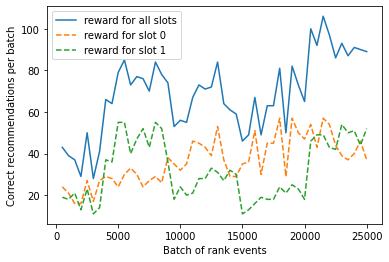

In [59]:
createChart(count, total_rewards, total_slot_rewards)

## Reading the chart

This chart shows the success of the model for the current default learning policy. 

The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, in the Configurations tab, under the RESOURCE MANAGEMENT section 

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-offline-evaluation) in the portal for your Personalizer loop.

## Run an offline evaluation

1. In the Azure portal, open the Personalizer resource's **Evaluations** page.
1. Select **Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include only the days you are focusing on for your evaluation. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization policy** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Comparison of different learning policies**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Validate new learning policy by running experiment for 5,000 iterations

Return to the Azure notebook, and continue by running the same loop but for only 5,000 iterations. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 10,000 calls, a rank and reward call for each iteration of the loop, the iterations are done. 

In [ ]:
# max iterations
num_requests = 5000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, total_rewards2, total_slot_rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2, 500)

## Run chart for 5,000 rank requests

Run the `createChart` function.

In [ ]:
createChart(count2, total_rewards2, total_slot_rewards2)

## Review the second chart

The second chart should show a visible increase in Rank predictions aligning with user preferences. 

## Clean up resources

If you do not intend to continue the tutorial series, clean up the following resources:

* Delete your Azure Notebook project. 
* Delete your Personalizer resource. 